# **TESTE-t DE PARA DUAS AMOSTRAS INDEPENDENTES**

O teste t para duas amostras compara a média de duas amostras
Tem como pressuposto que as amostras sejam normais e homogeneas.
Para isso abaixo, roramos o teste de homogeneidade e o de kolmogorov antes do teste - t


TESTE DE HOMOGENEIDADE DE BARTLETT

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
'''
TESTE DE HOMOGENEIDADE DE BARTLETT
As variancias das populacionais de k amostras sejam iguais
Implementacao do testes χ2 de Bartlett (1937),
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #para legendas manuais
import math
import scipy.stats as st
import random
from scipy.stats import norm
import statistics

class bartlettTest:
    def __init__(self, data_filename, amostras, variavel):
        #amostras - coluna das amostras a serem comparadas (como fatores aqui)
        #variavel - a variavel a ser testada entre amostras
        self.categorias = amostras
        self.variavel = variavel
        self.df = pd.read_csv(data_filename)
        self.k = self.df[self.categorias].nunique() # k e o numero de tratamentos (amostras)
        self.n = self.df.groupby(self.categorias).size()# eh o tamanho de cada amostra
        self.N = sum(self.n) # tamanho total
        self.runTest()

    def runTest(self):

        #calculando o q
        variancia = self.df.groupby(self.categorias)[self.variavel].var()
        Sp2 = sum((self.n-1)*variancia)/(self.N-self.k)
        q = (self.N-self.k)*np.log(Sp2)-(sum((self.n-1)*np.log(variancia)))
        #calculando o c
        c = 1+(1/(3*(self.k-1)))*(sum((1/(self.n-1))-(1/(self.N-self.k))))
       #Bcalculado
        Bcalc = q/c
        Bcritico = st.chi2.ppf(0.95, self.k-1)
        print(Bcritico)

        if(Bcalc > Bcritico):
            print("As amostras nao sao homogeneas")
        else:
            print("As amostras sao homogeneas")





TESTE DE NORMALIDADE

In [55]:
class KolmogorovSmirnovTest:
    def __init__(self, data_filename, target_column):
        #self.alpha = alpha
        self.data = pd.read_csv(data_filename)
        self.target_column = target_column
        self.prepare_data()
        self.calculate_expected()
        #self.run_test()


    def prepare_data(self):
        self.frequency_absolute = self.data[self.target_column].value_counts().reset_index()
        self.frequency_absolute.rename(columns={'index': 'X_i', self.target_column: 'Fabs'}, inplace=True)
        self.frequency_absolute = self.frequency_absolute.sort_values(by='X_i', ascending=True).reset_index(drop=True)
        self.frequency_absolute['Fac'] = np.cumsum(self.frequency_absolute['Fabs'])
        self.N_samples = sum(self.frequency_absolute['Fabs'])
        self.frequency_absolute['Fobs'] = self.frequency_absolute['Fac'] / self.N_samples
        mu = self.data[self.target_column].mean()
        sd = self.data[self.target_column].std()
        self.frequency_absolute['Zcalc'] = ((self.frequency_absolute['X_i'] - mu) / sd).round(2)

    def calculate_expected(self):
        m = len(self.frequency_absolute['Zcalc'])
        F_esp = []

        for z in range(0, m):
            value = st.norm.cdf(self.frequency_absolute['Zcalc'][z])
            F_esp.append(round(value, 4))

        self.frequency_absolute['Fesp'] = F_esp
        self.frequency_absolute['Exp(i)_Obs(i)'] = abs(np.array(F_esp) - self.frequency_absolute['Fobs'])

        Fesp_obs2 = [round(self.frequency_absolute['Fesp'][0], 4)]
        for i in range(1, len(F_esp)):
            value = F_esp[i] - self.frequency_absolute['Fobs'][i - 1]
            Fesp_obs2.append(value)

        self.frequency_absolute['Exp(i)_Obs(i-1)'] = Fesp_obs2

    def run_test(self):
        self.a_values = [0.05]

        max1 = max(self.frequency_absolute['Exp(i)_Obs(i)'])
        max2 = max(self.frequency_absolute['Exp(i)_Obs(i-1)'])
        self.D_calc = max(max1, max2)
        # Achar valor critico
        self.Dcrit_values = []  # Lista para armazenar os valores de Dcrit
        criticalV = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/kolmogorovCriticalvalues.csv")

        for alpha in self.a_values:
            if self.N_samples <= 35:
                row_index = criticalV[criticalV['n'] == self.N_samples].index[0]
                Dcrit = criticalV.loc[row_index][str(alpha)]
            else:
                match alpha:
                    case 0.2:
                        Dcrit = 1.07/math.sqrt(self.N_samples)
                    case 0.15:
                        Dcrit = 1.14/math.sqrt(self.N_samples)
                    case 0.1:
                        Dcrit = 1.22/math.sqrt(self.N_samples)
                    case 0.05:
                        Dcrit = 1.36/math.sqrt(self.N_samples)
                    case 0.01:
                        Dcrit = 1.63/math.sqrt(self.N_samples)
            self.Dcrit_values.append(round(Dcrit,3))  # Adicione o valor de Dcrit à lista

        self.resultado = []
        if(self.D_calc>Dcrit):
            print("Amostra nao segue distribuicao normal")
            return self.resultado == 1
        else:
            print("Amostra segue distribuicao normal")
            return self.resultado == 0






# **TESTE T**

In [66]:
import random
import numpy as np
from scipy.stats import t
import pandas as pd
from scipy.stats import norm
import statistics
import seaborn as sns
# t-student (teste - z): geralmente amostras < 30
# Teste t-Student quando o desvio-padrão populacional ( σ) não for conhecido

class Teste_T_2amostra: # teste t para uma amostra
        def __init__(self, alpha, data1, data2, homogeneidade):
                self.alpha = alpha
                self.amostra1 = pd.read_csv(data1)
                self.amostra2 = pd.read_csv(data2)
                self.homogeneidade = homogeneidade
                self.runTeste()
                #self.boxPlot()

        def runTeste(self):
                criticalT = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/TabeladoStudent.csv")
                if(self.homogeneidade == True):
                    # Realiza o teste t-Student para amostras homogêneas
                  stat, p_value = st.ttest_ind(self.amostra1['Variavel'], self.amostra2['Variavel'], equal_var=True)

                  # Define o nível de significância
                  alpha = self.alpha

                  # Compara o valor-p com o nível de significância
                  if p_value < alpha:
                      print("Rejeitamos a hipótese nula")
                      print("As médias das amostras são estatisticamente diferentes (com homogeneidade de variâncias).")
                  else:
                      print("Aceitamos a hipótese nula")
                      print("Não há evidência estatística de diferença nas médias das amostras (com homogeneidade de variâncias).") # ----------------------------------------------------------------------------------------------------------------------------------
                else:
                    media_am1 = self.amostra1['Variavel'].mean()
                    media_am2 = self.amostra2['Variavel'].mean()
                    var_am1 = self.amostra1['Variavel'].var()
                    var_am2 = self.amostra2['Variavel'].var()
                    n1 = len(self.amostra1['Variavel'])
                    n2 = len(self.amostra2['Variavel'])
                    t_calculado = (media_am1 - media_am2)/((var_am1/n1)+(var_am1/n2))**(1/2)

                    self.n1 = n1
                    self.n2 = n2
                    #grau de liberdade
                    gl = (n1+n2)-2
                    if (gl > 40):
                      # coloquei so esse da tabela Tabelado Studante pq tem uns cortes no gl,
                      #teria q achar uma mais detalhada, para cada gl
                        gl = 40 # so para facilitar abaixo coloquei ate 40

                    t_critico = criticalT[str(self.alpha)][gl-1]
                    if(t_calculado > t_critico):
                            print(f"Aceitamos H0 a um nível de {self.alpha*100}% de significância")
                            print(f"Media amostral NAO DIFERE da media informada")
                    else:
                            print(f"Rejeitamos H0 a um nível de {self.alpha*100}% de significância")
                            print(f"Media amostral DIFERE da media informada")


        def boxPlot(self):
            dados = pd.concat([self.amostra1, self.amostra2])
            categ = ["Amostra1" for _ in range(self.n1)] + ["Amostra2" for _ in range(self.n2)] # variavel categorica das duas amostras
            dados = pd.DataFrame({'Categorias': categ,'Variavel': dados['Variavel']})#, 'Categorias': categ
            sns.boxplot(x=dados['Categorias'], y=dados['Variavel'])


In [57]:
import random
import numpy as np
from scipy.stats import t
import pandas as pd
from scipy.stats import norm
import statistics
import seaborn as sns

class Teste_T_Amostras_Dependentes:
    def __init__(self, alpha, data1, data2):
        self.alpha = alpha
        self.amostra1 = pd.read_csv(data1)
        self.amostra2 = pd.read_csv(data2)
        self.runTeste()

    def runTeste(self):
        diff = self.amostra1['Variavel'] - self.amostra2['Variavel']
        n = len(diff)
        mean_diff = diff.mean()
        std_diff = diff.std(ddof=1)  # Usando ddof=1 para calcular o desvio padrão amostral
        t_calculado = mean_diff / (std_diff / np.sqrt(n))

        # Grau de liberdade
        gl = n - 1

        criticalT = t.ppf(1 - self.alpha/2, df=gl)
        t_critico = -criticalT, criticalT  # O intervalo de confiança de 95%

        if t_calculado > t_critico[1] or t_calculado < t_critico[0]:
            print(f"Rejeitamos H0 a um nível de {self.alpha*100}% de significância")
            print("A diferença entre as médias é estatisticamente significativa.")
        else:
            print(f"Aceitamos H0 a um nível de {self.alpha*100}% de significância")
            print("A diferença entre as médias não é estatisticamente significativa.")

    def boxPlot(self):
        dados = pd.concat([self.amostra1, self.amostra2])
        categ = ["Amostra1" for _ in range(len(self.amostra1))] + ["Amostra2" for _ in range(len(self.amostra2))]
        dados = pd.DataFrame({'Categorias': categ, 'Variavel': dados['Variavel']})
        sns.boxplot(x=dados['Categorias'], y=dados['Variavel'])

# **AMOSTRAS FORNECIDAS PELO PROFESSOR**



1) testando a normalidade

In [58]:
data1 = "/content/gdrive/MyDrive/Colab Notebooks/fornecedor1.csv"
data2 = '/content/gdrive/MyDrive/Colab Notebooks/fornecedor2.csv'
ks1 = KolmogorovSmirnovTest(data1, "Variavel")
ks2 = KolmogorovSmirnovTest(data2, "Variavel")
resultado = ks1.run_test()
resultado = ks2.run_test()

Amostra segue distribuicao normal
Amostra segue distribuicao normal


2) testando a homogeneidade

In [59]:
df = '/content/gdrive/MyDrive/Colab Notebooks/fornecedoresTotal.csv'
bt = bartlettTest(df, "Categorias", "Variavel")


3.841458820694124
As amostras sao homogeneas


3) Teste t independente

In [70]:
res = Teste_T_2amostra(0.05, data1, data2, True)

Rejeitamos a hipótese nula
As médias das amostras são estatisticamente diferentes (com homogeneidade de variâncias).


Rejeitamos H0 a um nível de 5.0% de significância
Media amostral DIFERE da media informada


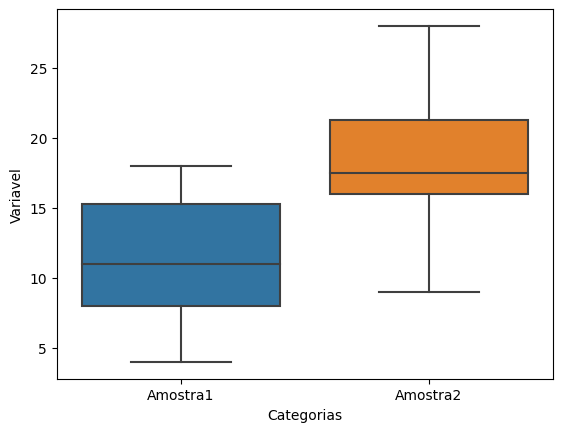

In [71]:
res = Teste_T_2amostra(0.05, data1, data2, False)
res.boxPlot()

4) Teste t dependente

Rejeitamos H0 a um nível de 5.0% de significância
A diferença entre as médias é estatisticamente significativa.


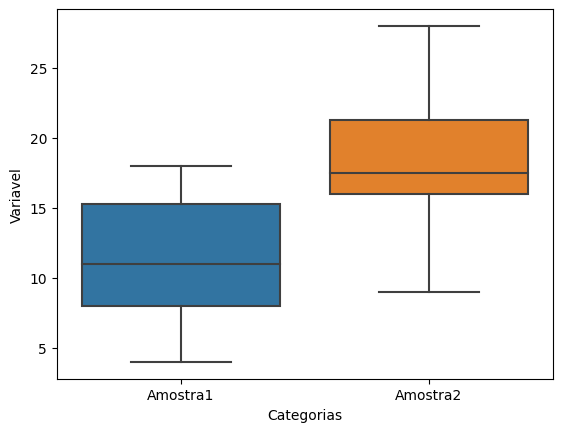

In [69]:
res = Teste_T_Amostras_Dependentes(0.05, data1, data2)
res.boxPlot()

#CRIANDO UM BANCO DE DADOS ALEATORIO PARA TESTE

1) Criando o dado e Testando a Homogeneidade

In [61]:
num_samples = 20
am1 = np.round(np.random.normal(10, 5, size=num_samples),0)
am2 = np.round(np.random.normal(20, 5, size=num_samples),0)
valor = np.concatenate((am1, am2))
categ = ["Amostra1" for _ in range(num_samples)] + ["Amostra2" for _ in range(num_samples)] # variavel categorica das duas amostras
randompd = pd.DataFrame({'Categorias': categ,'Variavel': valor})#, 'Categorias': categ
randompd.to_csv('/content/gdrive/MyDrive/Colab Notebooks/randompd.csv', index=False)
df = '/content/gdrive/MyDrive/Colab Notebooks/randompd.csv'

bt = bartlettTest(df, "Categorias", "Variavel")

3.841458820694124
As amostras sao homogeneas


2) Testando a normalidade

Divida o DataFrame com base na coluna "categoria",
pois preciso fazer o teste de normalidade para cada amostra


In [62]:
# pois preciso fazer o teste de normalidade para cada amostra
categorias = randompd['Categorias'].unique()
for categoria in categorias:
    sub_dataframe = randompd[randompd['Categorias'] == categoria]
    nome_arquivo = f"{'/content/gdrive/MyDrive/Colab Notebooks/'}{categoria}.csv"
    sub_dataframe.to_csv(nome_arquivo, index=False)

data1 = '/content/gdrive/MyDrive/Colab Notebooks/Amostra1.csv'
data2 = '/content/gdrive/MyDrive/Colab Notebooks/Amostra2.csv'
ks1 = KolmogorovSmirnovTest(data1, "Variavel")
ks2 = KolmogorovSmirnovTest(data2, "Variavel")

resultado = ks1.run_test()
resultado = ks2.run_test()

Amostra segue distribuicao normal
Amostra segue distribuicao normal
